This work was highly based on this [notebook](https://github.com/scikit-learn-contrib/MAPIE/blob/master/notebooks/regression/ts-changepoint.ipynb).

# Time series problem
Within this notebook, the "EnbPI" strategy ([Xu, Chen and Yao Xie (2021)](https://proceedings.mlr.press/v139/xu21h.html) ${}^{[1]}$) is implemented to estimate prediction intervals for time series' forecasts. In particular, the Victoria electricity demand dataset is used (as in the book: "Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos).

The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable. Thus, the features for this prediction problem will be:
- The lagged `n_lag` timestamps
- The week of year
- The weekday 
- The hour of the day
- The temperature 

A Random Forest model will be used to fit the data (fine-tuning it using a randomized hyperparameters search, leveraging a sequential [`sklearn.model_selection.TimeSeriesSplit`](sklearn.model_selection.TimeSeriesSplit) cross validation), and then 'EnbPI' will be implemented through the [`mapie.time_series_regression.MapieTimeSeriesRegressor`](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieTimeSeriesRegressor.html) class.

${}^{[1]}$ Xu, Chen and Yao Xie (July 2021). “Conformal prediction interval for dynamic time-series”. In: Proceedings of the 38th International Conference on Machine Learning. Ed. Bibliography 29 by Marina Meila and Tong Zhang. Vol. 139. Proceedings of Machine Learning Research. PMLR, pp. 11559–11569. URL: https://proceedings.mlr.press/v139/xu21h.html 

We will compare 2 strategies to quantify the uncertainty: applying 'EnbPI' with or without ``partial_fit`` called at every step. 

In [3]:
import os
import json  # to serialize the best hyperparameters found
import warnings  # to suppress them

from sklearn.ensemble import RandomForestRegressor

from cp import data, visualize, validate, ts, cv, logger as _logger
import matplotlib.pyplot as plt
import numpy as np

SEED: int = 123
np.random.seed(SEED)
MISCOVERAGE: float = 0.2 # MISCOVERAGE = alpha # CONFIDENCE = 1-alpha 
logger = _logger.Logger()
warnings.filterwarnings("ignore")  # to suppress them

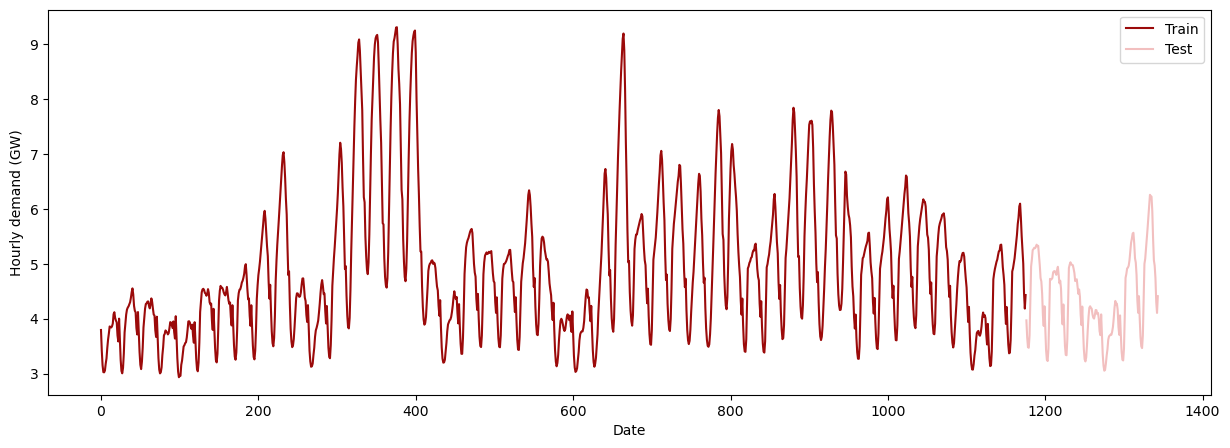

In [4]:
ts_problem = data.TimeSeriesProblem()
X_train, X_test, y_train, y_test = ts_problem.get_arrays()
ts_problem.visualize_data();

We first define perform a random search to find out which are the best hyperparameters for our random forest regressor (our base model):
- **Note:** it may take a while.

In [5]:
hyperparameters_serialization_file: str = "output/rf-hyperparameters.json"

if os.path.isfile(hyperparameters_serialization_file):
    logger.info("Retrieving best hyperparameters from local file")
    with open(hyperparameters_serialization_file, "r") as json_file:
        best_model_params: dict = json.load(json_file)
else:
    best_model_params = cv.fine_tune_rf_for_ts(X_train, y_train)
    with open(hyperparameters_serialization_file, "w") as json_file:
        json.dump(best_model_params, json_file, indent=4)

logger.info(f"The best hyperparameters found were: {best_model_params}")
best_model_params.update({'random_state': SEED, 'verbose': 0})

05/21/2024 08:03:43 PM     INFO >> Retrieving best hyperparameters from local file
05/21/2024 08:03:43 PM     INFO >> The best hyperparameters found were: {'max_depth': 23, 'n_estimators': 99}


### Training & inference

In [6]:
strategy_name: dict = {
    'EnbPI_nP': 'Ensemble of bootstrap Prediction Intervals (w/o partial fit)',
    'EnbPI': 'Ensemble of bootstrap Prediction Intervals'
}
base_model: dict = {
    'EnbPI_nP': RandomForestRegressor(**best_model_params),
    'EnbPI': RandomForestRegressor(**best_model_params)
}
y_pred, int_pred, mapie_estimator = {}, {}, {}
 
mapie_estimator['EnbPI_nP'], y_pred['EnbPI_nP'], int_pred['EnbPI_nP'] = ts.train_without_partial_fit(
    X_train, y_train, X_test, MISCOVERAGE, 
    RandomForestRegressor(**best_model_params)
)
mapie_estimator['EnbPI'], y_pred['EnbPI'], int_pred['EnbPI'] = ts.train(
    X_train, y_train, X_test, y_test, MISCOVERAGE, 
    RandomForestRegressor(**best_model_params)
)

05/21/2024 08:03:44 PM     INFO >> Traning EnbPI without partial fit to adjust residuals
05/21/2024 08:03:44 PM    DEBUG >>     This may take a while
05/21/2024 08:03:52 PM     INFO >> Inferring
05/21/2024 08:03:52 PM     INFO >> Traning EnbPI
05/21/2024 08:03:52 PM    DEBUG >>     This may take a while
05/21/2024 08:03:59 PM     INFO >> Inferring while adjusting residuals (partial fit)
05/21/2024 08:03:59 PM    DEBUG >>     Adjusting residuals for step 1
05/21/2024 08:04:00 PM    DEBUG >>     Adjusting residuals for step 2
05/21/2024 08:04:00 PM    DEBUG >>     Adjusting residuals for step 3
05/21/2024 08:04:00 PM    DEBUG >>     Adjusting residuals for step 4
05/21/2024 08:04:01 PM    DEBUG >>     Adjusting residuals for step 5
05/21/2024 08:04:01 PM    DEBUG >>     Adjusting residuals for step 6
05/21/2024 08:04:02 PM    DEBUG >>     Adjusting residuals for step 7
05/21/2024 08:04:02 PM    DEBUG >>     Adjusting residuals for step 8
05/21/2024 08:04:02 PM    DEBUG >>     Adjusting r

### Computing metrics

In [ ]:
coverages: dict = validate.coverage(int_pred, y_test)
widths: dict = validate.width(int_pred)
rmse: dict = validate.rmse(y_pred, y_test)
cwc: dict = validate.cwc(int_pred, y_test, MISCOVERAGE, eta=10)